In [3]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

# everywhere else
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import random
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix, roc_curve

# custom code
from utils.datasets import *
from utils.config import *
from utils.network import *
from utils.netMixin import *
from utils.tester import *

# some misc modules
from os import listdir
from os.path import isfile, join

# init the torch seeds
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(100)
torch.cuda.manual_seed(100)
np.random.seed(100)
random.seed(100)

# Model 1

## Training

In [4]:
#---------------- prep data for training of first model ------------------#
# positive_class would be the assigned to the data from class 0, while the data from other classes would take the negative class
positive_class = 0 # options: {0:'normal', 1:'infected_covid', 2:'infected_non-covid'} 
exclude_class = None # options: {None, 0:'normal', 1:'infected_covid', 2:'infected_non-covid' }
datasets = {'train': lung_bin_train_dataset(positive_class, exclude_class=exclude_class),
              'validation': lung_bin_val_dataset(positive_class, exclude_class=exclude_class),
              'test': lung_bin_test_dataset(positive_class, exclude_class=exclude_class)}
trainloader, validloader, testloader = load_data(datasets, hyperparams['dataloader']['params'])


# preprocessing
preprocessing_params = hyperparams['preprocessing']
kernel = preprocessing_params['gaussian_blur']['kernel']
degrees = preprocessing_params['affine']['degrees']
probability = preprocessing_params['flip']['probability']

rand_transforms = transforms.RandomChoice([
    transforms.RandomVerticalFlip(probability),
    transforms.GaussianBlur(kernel),
    transforms.RandomAffine(degrees)
])

for dataset in datasets.values():
  dataset.set_tx(transforms.Compose([
                                  rand_transforms,
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])
                                  ]))

In [5]:
#--------------- training ---------------------#
# init the model
lungDetector1 = LungDetectorModel(1)

# hyperparams 
model_params = hyperparams['model']
lr = model_params['lr']
eps = model_params['eps']
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lungDetector1.parameters(), lr=lr)

# train the model
_, losses = lungDetector1.train_model(
    trainloader,
    validloader,
    eps,
    optimizer,
    criterion
)

Epoch 1 of 10 @ 21-03-2021 12:47:47




Average training loss: 0.010325625281712394
Calculating performance on validation set



Validation Loss: 0.036
Validation Accuracy: 0.680

Epoch 2 of 10 @ 21-03-2021 12:47:58




Average training loss: 0.005770703665540765
Calculating performance on validation set



Validation Loss: 0.022
Validation Accuracy: 0.680

Epoch 3 of 10 @ 21-03-2021 12:48:09




Average training loss: 0.005002397074338414
Calculating performance on validation set



Validation Loss: 0.028
Validation Accuracy: 0.680

Epoch 4 of 10 @ 21-03-2021 12:48:19




Average training loss: 0.004524033954988399
Calculating performance on validation set



Validation Loss: 0.029
Validation Accuracy: 0.680

Epoch 5 of 10 @ 21-03-2021 12:48:30




Average training loss: 0.004192192084227398
Calculating performance on validation set



Validation Loss: 0.036
Validation Accuracy: 0.680

Epoch 6 of 10 @ 21-03-2021 12:48:40




Average training loss: 0.00402072890221707
Calculating performance on validation set



Validation Loss: 0.022
Validation Accuracy: 0.680

Epoch 7 of 10 @ 21-03-2021 12:48:51




Average training loss: 0.0037343358512799273
Calculating performance on validation set



Validation Loss: 0.028
Validation Accuracy: 0.680

Epoch 8 of 10 @ 21-03-2021 12:49:02




Average training loss: 0.0036157537239212313
Calculating performance on validation set



Validation Loss: 0.034
Validation Accuracy: 0.680

Epoch 9 of 10 @ 21-03-2021 12:49:12




Average training loss: 0.003440096129469025
Calculating performance on validation set



Validation Loss: 0.014
Validation Accuracy: 0.680

Epoch 10 of 10 @ 21-03-2021 12:49:23




Average training loss: 0.003464713242180657
Calculating performance on validation set



Validation Loss: 0.027
Validation Accuracy: 0.680



In [6]:
#--------------- save model -----------------#
if overwrite:
  filename = FINAL_MODEL1_NAME + '.pt'
  lungDetector1.save_model(MODELS_DIR + filename)

In [7]:
#---------------- Save and plot the training results -------------------#
losses = torch.Tensor(losses).T

# Save the results if overwrite is true
if overwrite:
  print('overwriting results')
  torch.save(losses, 'results/{}_results.pt'.format(FINAL_MODEL1_NAME))

# plot losses
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Losses')
ax1.set_xlabel('Epochs')
fig.set_figheight(5)
fig.set_figwidth(15)

# plot the loss values
for loss, name in zip(losses[1:],['Average training loss', 'Validation Loss']):
  plt.plot(losses[0], loss, '--o', linewidth=2, label=name)

plt.legend(loc="upper right")
plt.show() 

## Testing and results

In [8]:
#----------------- Plot ROC curve ----------------#
# get the sigmoided values from the model
a, probs = bin_get_probs(lungDetector1, testloader, 'cuda')

# get the false positive rates, true positive rates, and thresholds for the roc_curve
fpr, tpr, thresholds = roc_curve(a, probs)

# plot the figure
plt.figure()
plt.title('model1 roc curve')
plt.plot(fpr, tpr, 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
thresholdsLength = len(thresholds)
for i in range(0, thresholdsLength, 10):
    threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
    plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 8})

# get the array of differences between tpr and fpr, and get the index for the best threshold value for model 1 
J = tpr - fpr
ix = np.argmax(J)
thresh1 = thresholds[ix]

print('Best threshold value is: {}'.format(thresh1))

Evaluating on test set



Best threshold value is: 0.010019022040069103


In [9]:
#--------------- test the model on the test set ------------------#
_, predicted, actual = test_bin_model(lungDetector1, testloader, criterion, 'cuda', thresh=thresh1)
print(f'Accuracy: {(predicted == actual).sum().item() / len(actual)}')

Evaluating on given set



Average test loss: 0.02569972506868161
Accuracy: 0.848780487804878


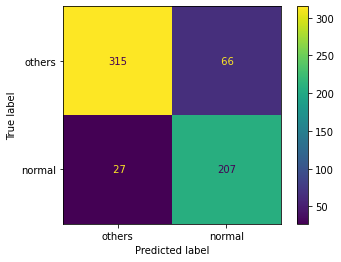

In [10]:
#--------------------- display results from test ------------------------#
cm = confusion_matrix(actual, predicted)
labels = ['others','normal']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format='3d')
plt.show()

# Model 2

## Training

In [11]:
#---------------- prep data for training of second model ------------------#
# positive_class would be the assigned to the data from class 2, while the data from other classes would take the negative class
# exclude_class would be the class to be excluded
positive_class = 2
exclude_class = 0 # options: {None, 0:'normal', 1:'infected_covid', 2:'infected_non-covid' }
datasets = {'train': lung_bin_train_dataset(positive_class, exclude_class=exclude_class),
              'validation': lung_bin_val_dataset(positive_class, exclude_class=exclude_class),
              'test': lung_bin_test_dataset(positive_class, exclude_class=exclude_class)}
trainloader, validloader, testloader = load_data(datasets, hyperparams['dataloader']['params'])

# preprocessing
preprocessing_params = hyperparams['preprocessing']
kernel = preprocessing_params['gaussian_blur']['kernel']
degrees = preprocessing_params['affine']['degrees']
probability = preprocessing_params['flip']['probability']

rand_transforms = transforms.RandomChoice([
    transforms.RandomVerticalFlip(probability),
    transforms.GaussianBlur(kernel),
    transforms.RandomAffine(degrees)
])

for dataset in datasets.values():
  dataset.set_tx(transforms.Compose([
                                  rand_transforms,
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])
                                  ]))

In [12]:
#--------------- training ---------------------#
# init the model
lungDetector2 = LungDetectorModel(1)

# hyperparams 
model_params = hyperparams['model']
lr = model_params['lr']
eps = model_params['eps']
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lungDetector2.parameters(), lr=lr)

# train the model
_, losses = lungDetector2.train_model(
    trainloader,
    validloader,
    eps,
    optimizer,
    criterion
)

Epoch 1 of 10 @ 21-03-2021 12:49:37




Average training loss: 0.01992817025030813
Calculating performance on validation set



Validation Loss: 0.039
Validation Accuracy: 0.529

Epoch 2 of 10 @ 21-03-2021 12:49:45




Average training loss: 0.018310477172174763
Calculating performance on validation set



Validation Loss: 0.038
Validation Accuracy: 0.529

Epoch 3 of 10 @ 21-03-2021 12:49:53




Average training loss: 0.01806991587915728
Calculating performance on validation set



Validation Loss: 0.035
Validation Accuracy: 0.529

Epoch 4 of 10 @ 21-03-2021 12:50:01




Average training loss: 0.017689852868357014
Calculating performance on validation set



Validation Loss: 0.034
Validation Accuracy: 0.529

Epoch 5 of 10 @ 21-03-2021 12:50:09




Average training loss: 0.0176718804067181
Calculating performance on validation set



Validation Loss: 0.035
Validation Accuracy: 0.529

Epoch 6 of 10 @ 21-03-2021 12:50:17




Average training loss: 0.017525966452014062
Calculating performance on validation set



Validation Loss: 0.035
Validation Accuracy: 0.529

Epoch 7 of 10 @ 21-03-2021 12:50:25




Average training loss: 0.017527778810070407
Calculating performance on validation set



Validation Loss: 0.035
Validation Accuracy: 0.529

Epoch 8 of 10 @ 21-03-2021 12:50:33




Average training loss: 0.017318697244890276
Calculating performance on validation set



Validation Loss: 0.037
Validation Accuracy: 0.529

Epoch 9 of 10 @ 21-03-2021 12:50:41




Average training loss: 0.017232216435094032
Calculating performance on validation set



Validation Loss: 0.037
Validation Accuracy: 0.529

Epoch 10 of 10 @ 21-03-2021 12:50:48




Average training loss: 0.017104337984515775
Calculating performance on validation set



Validation Loss: 0.036
Validation Accuracy: 0.529



In [13]:
#--------------- save model -----------------#
if overwrite:
  filename = FINAL_MODEL2_NAME + '.pt'
  lungDetector2.save_model(MODELS_DIR + filename)

In [14]:
#---------------- Save and plot the training results -------------------#
losses = torch.Tensor(losses).T

# Save the results if overwrite is true
if overwrite:
  print('overwriting results')
  torch.save(losses, 'results/{}.pt'.format(FINAL_MODEL2_NAME))

# plot losses
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Losses')
ax1.set_xlabel('Epochs')
fig.set_figheight(5)
fig.set_figwidth(15)

# plot the loss values
for loss, name in zip(losses[1:],['Average training loss', 'Validation Loss']):
  plt.plot(losses[0], loss, '--o', linewidth=2, label=name)

plt.legend(loc="upper right")
plt.show() 

## Testing and results

Evaluating on test set



Best threshold value is: 0.5608626008033752


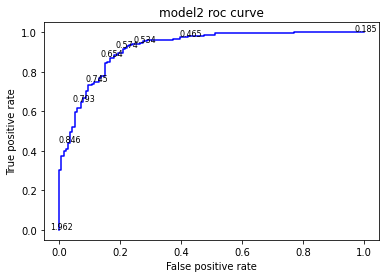

In [15]:
#----------------- Plot ROC curve ----------------#
# get the sigmoided values from the model
a, probs = bin_get_probs(lungDetector2, testloader, 'cuda')

# get the false positive rates, true positive rates, and thresholds for the roc_curve
fpr, tpr, thresholds = roc_curve(a, probs)

# plot the figure
plt.figure()
plt.title('model2 roc curve')
plt.plot(fpr, tpr, 'b')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
thresholdsLength = len(thresholds)
for i in range(0, thresholdsLength, 10):
    threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
    plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 8})

# get the array of differences between tpr and fpr, and get the index for the best threshold value for model 2
J = tpr - fpr
ix = np.argmax(J)
thresh2 = thresholds[ix]

print('Best threshold value is: {}'.format(thresh2))

In [16]:
#--------------- test the model on the test set ------------------#
_, predicted, actual = test_bin_model(lungDetector2, testloader, criterion, 'cuda', thresh=thresh2)
print(f'Accuracy: {(predicted == actual).sum().item() / len(actual)}')

Evaluating on given set



Average test loss: 0.012917380789759278
Accuracy: 0.863517060367454


In [17]:
#--------------------- display results from test ------------------------#
cm = confusion_matrix(actual, predicted, normalize='true')
labels = list(datasets['test'].classes.values())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

# Stacked model (Testing of Model 1 + 2)

In [18]:
#--------------load both models ------------#
model1 = LungDetectorModel(1)
model1.load_model(MODELS_DIR + FINAL_MODEL1_NAME + '.pt')

model2 = LungDetectorModel(1)
model2.load_model(MODELS_DIR + FINAL_MODEL2_NAME + '.pt')

In [19]:
#-------------- prep the test data -----------------#
test_datasets = {'full': lung_dataset(),'train': lung_train_dataset(), 'validation': lung_val_dataset(), 'test': lung_test_dataset()}
_, _, testloader = load_data(test_datasets, hyperparams['dataloader']['params'])

# preprocessing
for dataset in test_datasets.values():
  dataset.set_tx(transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])
                                  ]))


In [20]:
#------------ make predictions --------------#
predictions, truth = test_bin_class_model(model1, model2, 0, 2, testloader, model1_thresh=thresh1, model2_thresh=thresh2)
print(f'Accuracy: {(predictions == truth).sum().item() / len(truth)}')

Evaluating on given set



Accuracy: 0.7902439024390244


# Results

In [21]:
#------------- display 3 class confusion matrix ---------------#
cm = confusion_matrix(truth, predictions, normalize='true')
labels = list(test_datasets['test'].classes.values())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

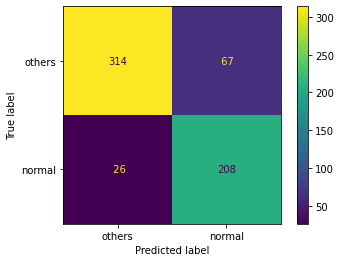

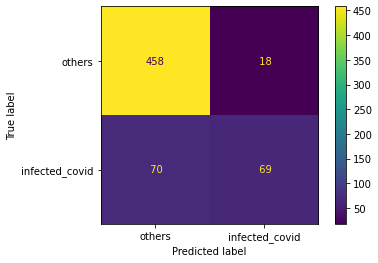

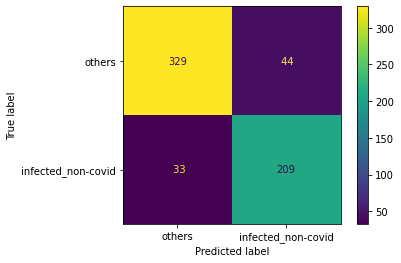

In [22]:
#--------------- display confusion matrix for individual class ------------------#
multilabel_cm = multilabel_confusion_matrix(truth, predictions)
for cls in list(test_datasets['test'].classes.values()):
  i = list(test_datasets['test'].classes.values()).index(cls)
  disp = ConfusionMatrixDisplay(confusion_matrix=multilabel_cm[i], display_labels=['others', cls])
  disp.plot(values_format='3d') 